In [ ]:
import cv2
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import urllib
from urllib.request import urlopen

%matplotlib inline

Python implementation of image retina transformation obtainde from repo https://github.com/ouyangzhibo/Image_Foveation_Python . Algorithm replicated from the  following papers:

Perry, Jeffrey S., and Wilson S. Geisler. "Gaze-contingent real-time simulation of arbitrary visual fields." Human vision and electronic imaging VII. Vol. 4662. International Society for Optics and Photonics, 2002.

Jiang, Ming, et al. "Salicon: Saliency in context." Proceedings of the IEEE conference on computer vision and pattern recognition. 2015.



In [ ]:
def genGaussiankernel(width, sigma):
    # gaussian weighting function is used to smoothen the image before downsampling
    x = np.arange(-int(width/2), int(width/2)+1, 1, dtype=np.float32)
    x2d, y2d = np.meshgrid(x, x)
    kernel_2d = np.exp(-(x2d ** 2 + y2d ** 2) / (2 * sigma ** 2))
    kernel_2d = kernel_2d / np.sum(kernel_2d)
    return kernel_2d

def pyramid(im, sigma=1, prNum=6):
    height_ori, width_ori, ch = im.shape
    G = im.copy()
    pyramids = [G]
    
    # gaussian blur
    # using 5x5 kernel
    Gaus_kernel2D = genGaussiankernel(5, sigma)
    
    # downsample
    for i in range(1, prNum):
        # smoothen the image to prevent sharp artifacts
        G = cv2.filter2D(G, -1, Gaus_kernel2D)
        height, width, _ = G.shape
        # down sample the image by half in both the dimensions
        G = cv2.resize(G, (int(width/2), int(height/2)))
        pyramids.append(G)
    
    
    # upsample ahead and store for the next stages
    for i in range(1, 6):
        curr_im = pyramids[i]
        for j in range(i):
            if j < i-1:
                im_size = (curr_im.shape[1]*2, curr_im.shape[0]*2)
            else:
                im_size = (width_ori, height_ori)
            curr_im = cv2.resize(curr_im, im_size)
            curr_im = cv2.filter2D(curr_im, -1, Gaus_kernel2D)
        pyramids[i] = curr_im

    return pyramids

def foveat_img(im, fixs):
    """
    im: input image
    fixs: sequences of fixations of form [(x1, y1), (x2, y2), ...]
    These fixation coordinates act as centers of foveations
    
    This function outputs the foveated image with given input image and fixations.
    """
    sigma=0.248
    prNum = 6
    As = pyramid(im, sigma, prNum)
    height, width, _ = im.shape
    
    # coeffs for foveations formulas

    p = 7.5     # number of pixels a person can see in a degree of visual angle
    # which can be changed to simulate different viewing distances
    k = 3
    alpha = 2.5 # half-angle height means that when θ(x, y) = α the image will become only 
    # half the resolution of the center of attention (θ(x, y) = 0), where θ is the visual angel subtended by center of foveation

    x = np.arange(0, width, 1, dtype=np.float32)
    y = np.arange(0, height, 1, dtype=np.float32)
    x2d, y2d = np.meshgrid(x, y)
    theta = np.sqrt((x2d - fixs[0][0]) ** 2 + (y2d - fixs[0][1]) ** 2) / p
    for fix in fixs[1:]:
        theta = np.minimum(theta, np.sqrt((x2d - fix[0]) ** 2 + (y2d - fix[1]) ** 2) / p)

    # resolution map    
    R = alpha / (theta + alpha)
    
    # transfer function
    Ts = []
    for i in range(1, prNum):
        Ts.append(np.exp(-((2 ** (i-3)) * R / sigma) ** 2 * k))
    Ts.append(np.zeros_like(theta))

    # omega
    omega = np.zeros(prNum)
    for i in range(1, prNum):
        omega[i-1] = np.sqrt(np.log(2)/k) / (2**(i-3)) * sigma

    omega[omega>1] = 1

    # layer index
    layer_ind = np.zeros_like(R)
    for i in range(1, prNum):
        ind = np.logical_and(R >= omega[i], R <= omega[i - 1])
        layer_ind[ind] = i

    # Blending function
    Bs = []
    for i in range(1, prNum):
        Bs.append((0.5 - Ts[i]) / (Ts[i-1] - Ts[i] + 1e-5))

    # Ms: final output layers
    Ms = np.zeros((prNum, R.shape[0], R.shape[1]))

    for i in range(prNum):
        ind = layer_ind == i
        if np.sum(ind) > 0:
            if i == 0:
                Ms[i][ind] = 1
            else:
                Ms[i][ind] = 1 - Bs[i-1][ind]

        ind = layer_ind - 1 == i
        if np.sum(ind) > 0:
            Ms[i][ind] = Bs[i][ind]

    print('num of full-res pixel', np.sum(Ms[0] == 1))
    # generate periphery image
    im_fov = np.zeros_like(As[0], dtype=np.float32)
    for M, A in zip(Ms, As):
        for i in range(3):
            im_fov[:, :, i] += np.multiply(M, A[:, :, i])

    im_fov = im_fov.astype(np.uint8)
    return im_fov



To adjust the degree of blur and size of the foveal region (full-reolustion pixels), one can increase or decrease the value of 'k' and 'p' and 'alpha' in the function ''foveat_img''

In [ ]:
from skimage import io

# reading images directly off a link
female_link = "https://sipi.usc.edu/database/download.php?vol=misc&img=4.1.01"
plane_link = "https://sipi.usc.edu/database/download.php?vol=misc&img=4.2.05"


female_img = io.imread( female_link )
plane_img = io.imread( plane_link )


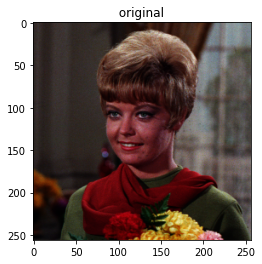

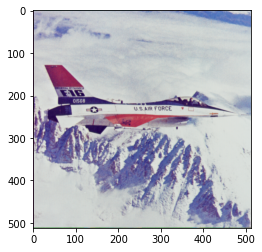

In [ ]:
# displaying the images
plt.imshow(female_img)
plt.title(" original ")
plt.show()

plt.imshow(plane_img)
plt.show()

In [ ]:
# ours is a simple verison whic foveates any image w.r.t its center

def get_center(im):
  xc, yc = int(im.shape[1]/2), int(im.shape[0]/2)

  return xc, yc

In [ ]:
# printing function to print images side by side

def show_pair_sidebyside(im1, im2, title1, title2):
  _, ax = plt.subplots(1,2)
  ax[0].title.set_text(title1)
  ax[0].imshow(im1, cmap='gray')
  ax[1].title.set_text(title2)
  ax[1].imshow(im2, cmap='gray'); plt.show()

num of full-res pixel 1321


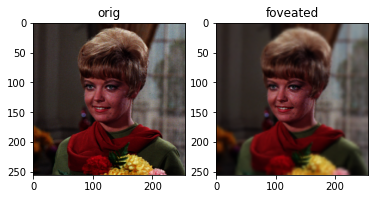

In [ ]:
x, y = get_center(female_img)
feamle_fov = foveat_img(female_img, [(x,y)])
#plt.imshow(feamle_fov)
#plt.title("foveated")
#plt.show()
show_pair_sidebyside(female_img, feamle_fov, 'orig', 'foveated')

num of full-res pixel 1321


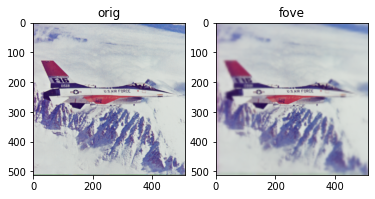

In [ ]:
x, y = get_center(plane_img)
plane_fov = foveat_img(plane_img, [(x,y)])

#plt.imshow(plane_fov)
#plt.show()

show_pair_sidebyside(plane_img, plane_fov, 'orig', 'fove')